In [2]:
import warnings

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [3]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 12.1

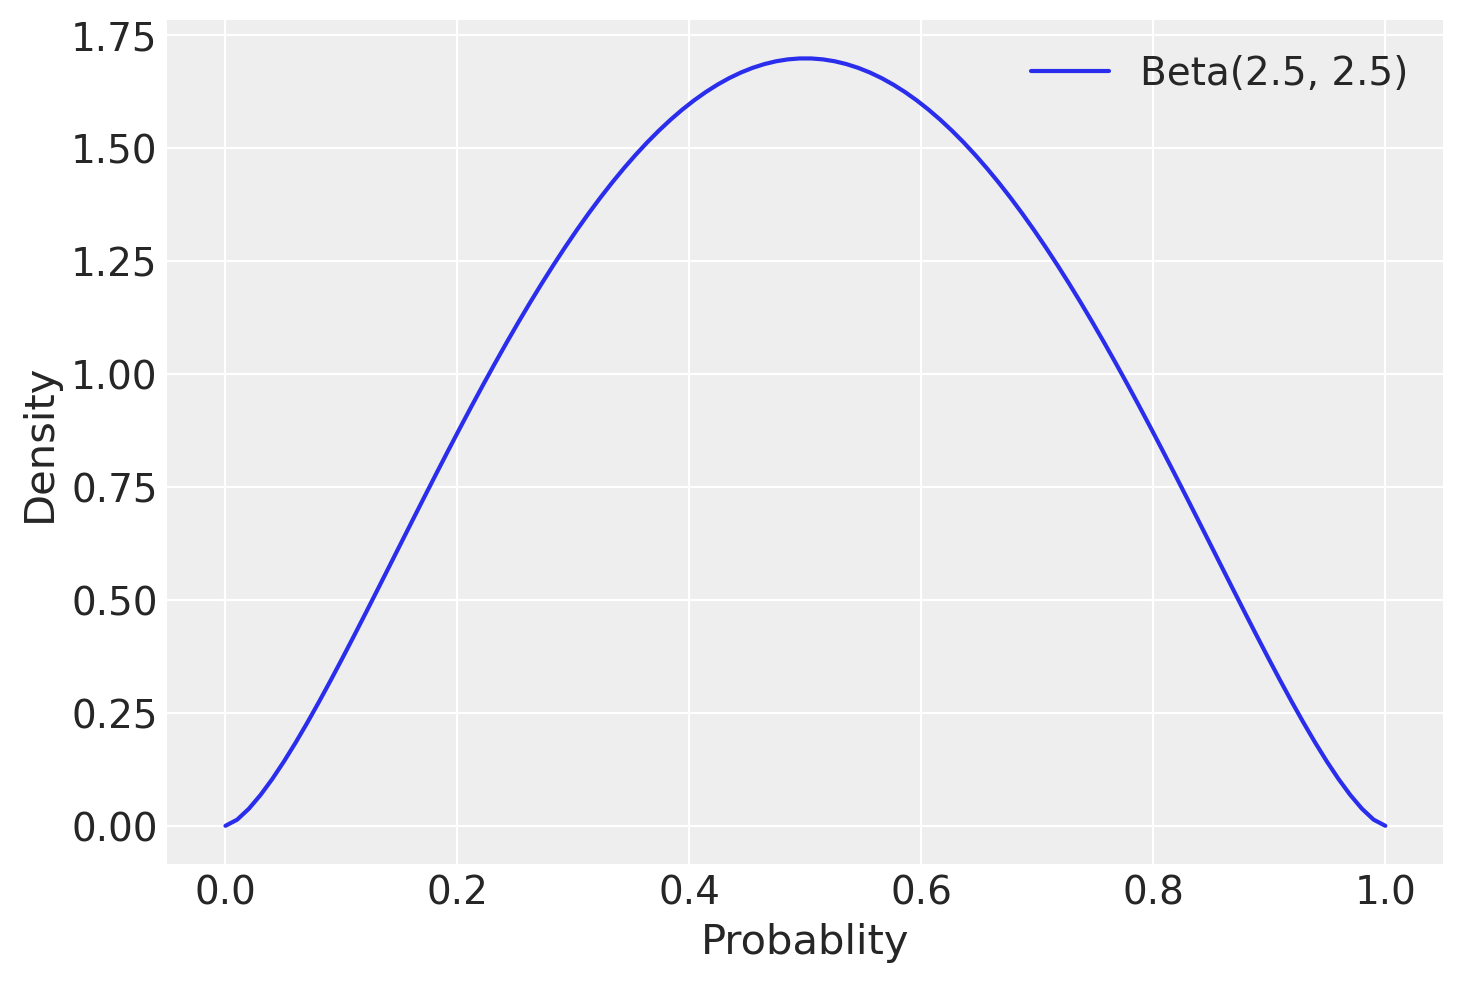

In [4]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 5.0
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot[:, np.newaxis], pbar * theta, (1 - pbar) * theta),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

#### Code 12.2

In [5]:
admit_df = pd.read_csv("Data/UCBadmit.csv", sep=";")
N = admit_df.applications.values
gid = (admit_df["applicant.gender"] == "female").astype(int).values
admit_df.head()

dept applicant.gender  admit  reject  applications
1    A             male    512     313           825
2    A           female     89      19           108
3    B             male    353     207           560
4    B           female     17       8            25
5    C             male    120     205           325

In [6]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0.0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1.0)

    theta = pm.Deterministic("theta", phi + 2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))

    A = pm.BetaBinomial("A", pbar * theta, (1.0 - pbar) * theta, N, observed=admit_df.admit.values)

    trace_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


#### Code 12.3

In [7]:
az.summary(trace_12_1, var_names=["a", "phi", "theta"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0]  -0.45  0.40     -1.09       0.21       0.01     0.01   2817.14   
a[1]  -0.32  0.41     -0.97       0.34       0.01     0.01   2624.66   
phi    1.04  0.78      0.00       2.07       0.01     0.01   2072.57   
theta  3.04  0.78      2.00       4.07       0.01     0.01   2072.57   

       ess_tail  r_hat  
a[0]    2539.45    1.0  
a[1]    2656.98    1.0  
phi     1418.14    1.0  
theta   1418.14    1.0

In [8]:
post_a = az.extract_dataset(trace_12_1["posterior"])["a"]
diff_a = post_a[0, :] - post_a[1, :]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
diff_a -0.13  0.57     -0.95       0.86

#### Code 12.4

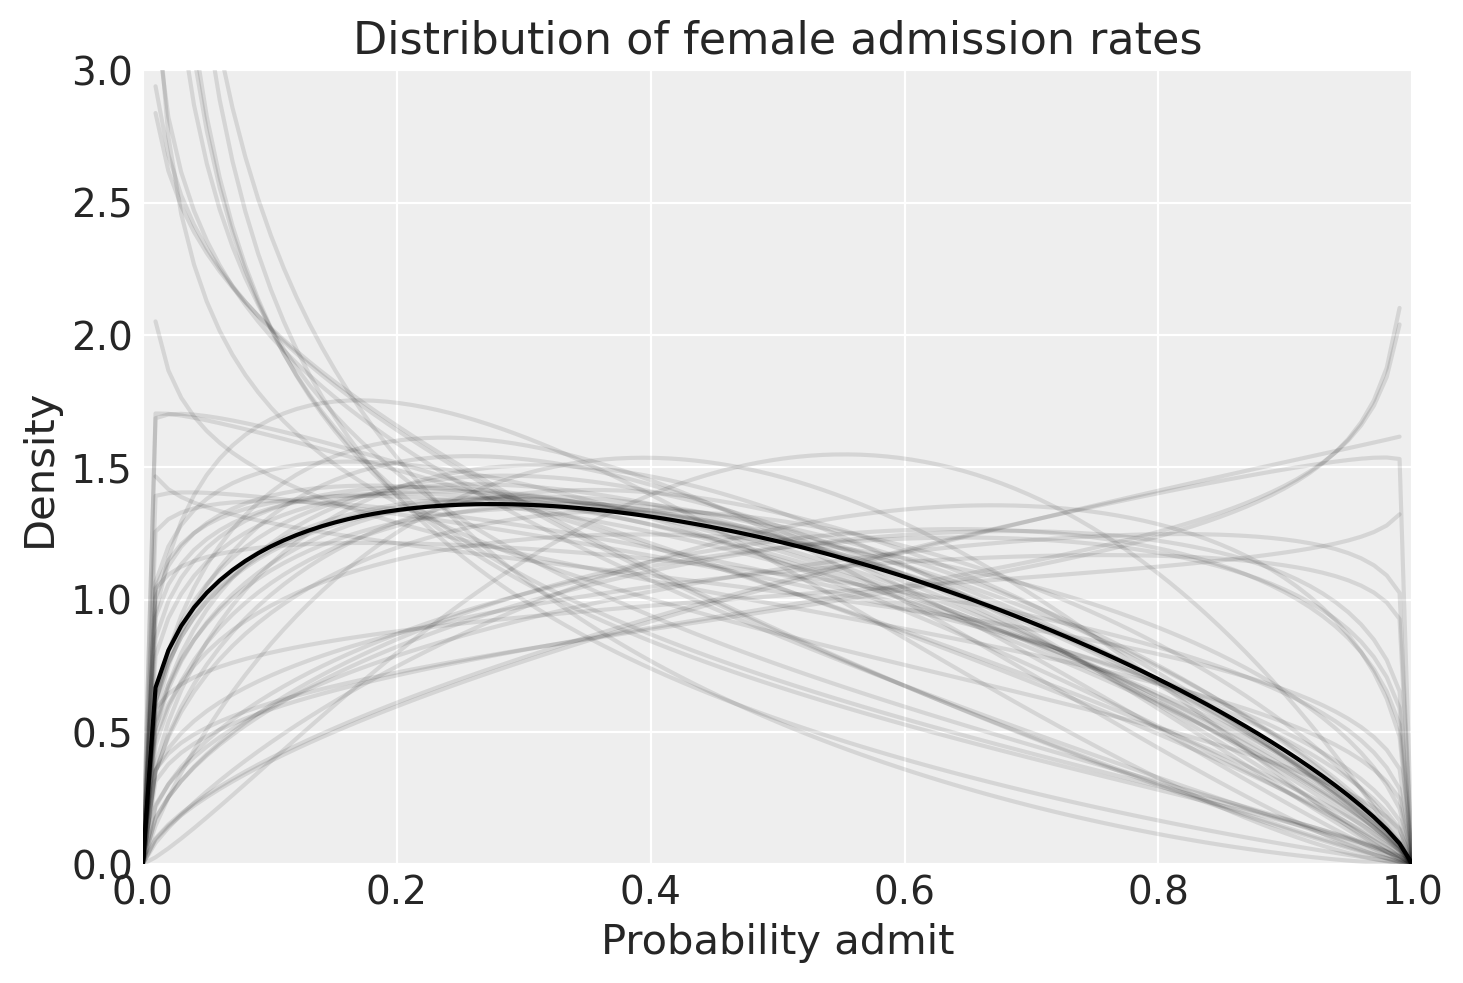

In [9]:
gid = 1
x_plot = np.linspace(0, 1, 100)
post_theta = az.extract_dataset(trace_12_1["posterior"])["theta"]

# draw posterior mean beta distribution:
pbar_mean = logistic(post_a[gid, :]).mean()
theta_mean = post_theta.mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1.0 - pbar_mean) * theta_mean),
    c="k",
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(post_a[gid, :])[:50] * post_theta[:50],
        (1.0 - logistic(post_a[gid, :])[:50]) * post_theta[:50],
    ),
    c="k",
    alpha=0.1,
)

plt.xlim(0.0, 1.0)
plt.xlabel("Probability admit")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

#### Code 12.5

In [10]:
with m12_1:
    ppc = pm.sample_posterior_predictive(trace_12_1, random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]["A"]
pp_admit = ppc / N

Sampling: [A]


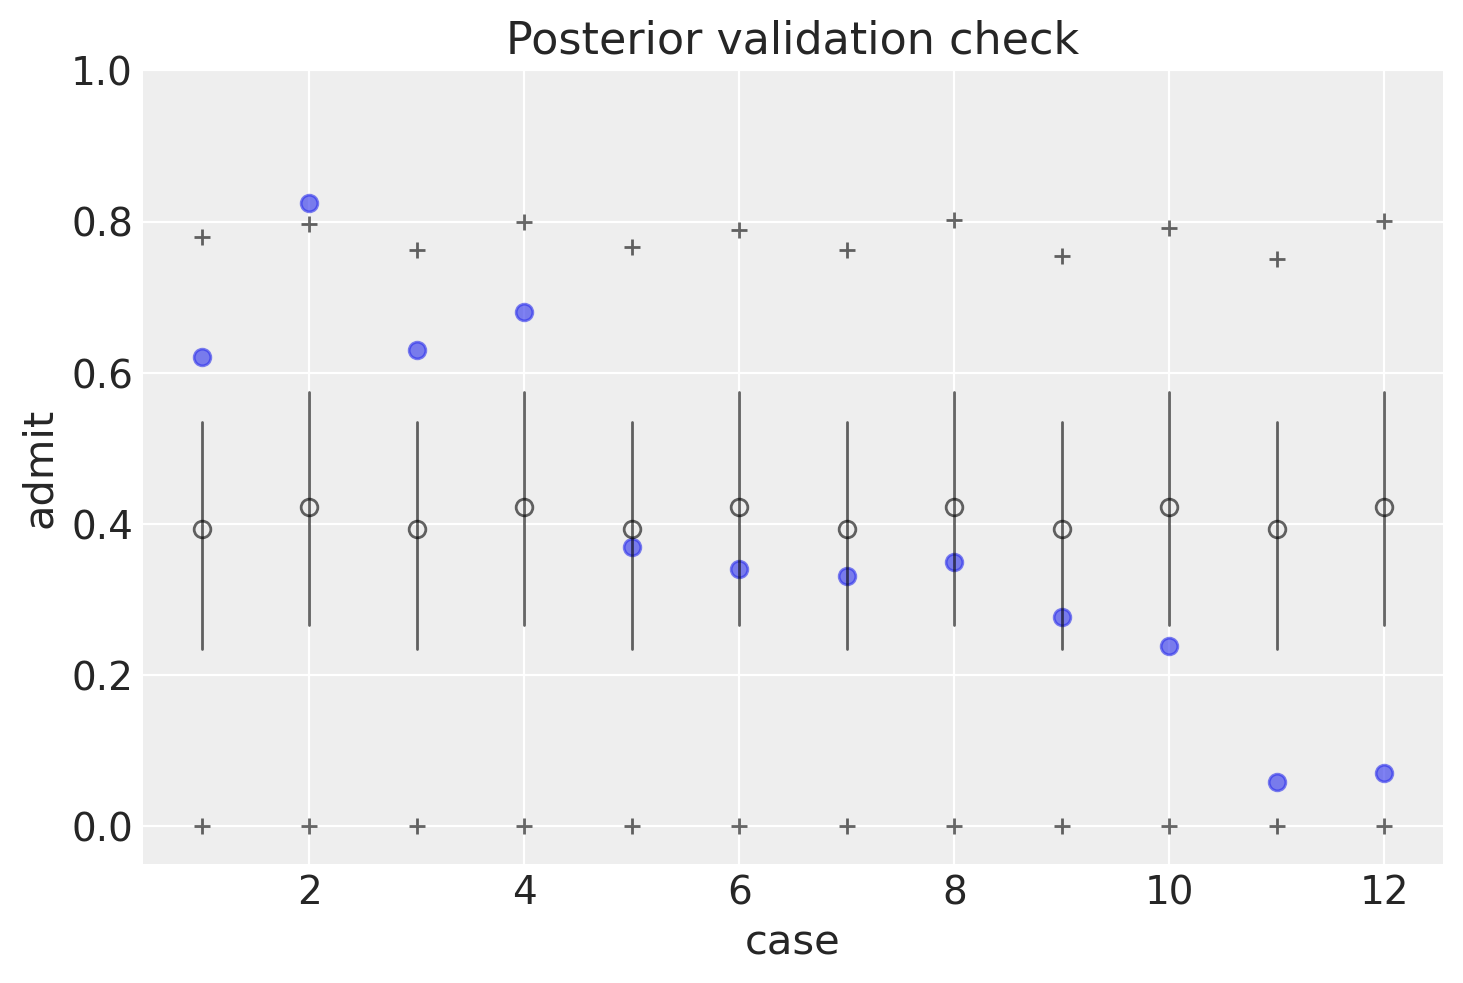

In [11]:
plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(
    range(1, 13),
    trace_12_1["posterior"]["pbar"].mean(["chain", "draw"]),
    "ko",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)
plt.plot(
    [range(1, 13), range(1, 13)],
    az.hdi(trace_12_1["posterior"]["pbar"])["pbar"].T,
    "k-",
    lw=1,
    alpha=0.6,
)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit)["A"].T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### Code 12.6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


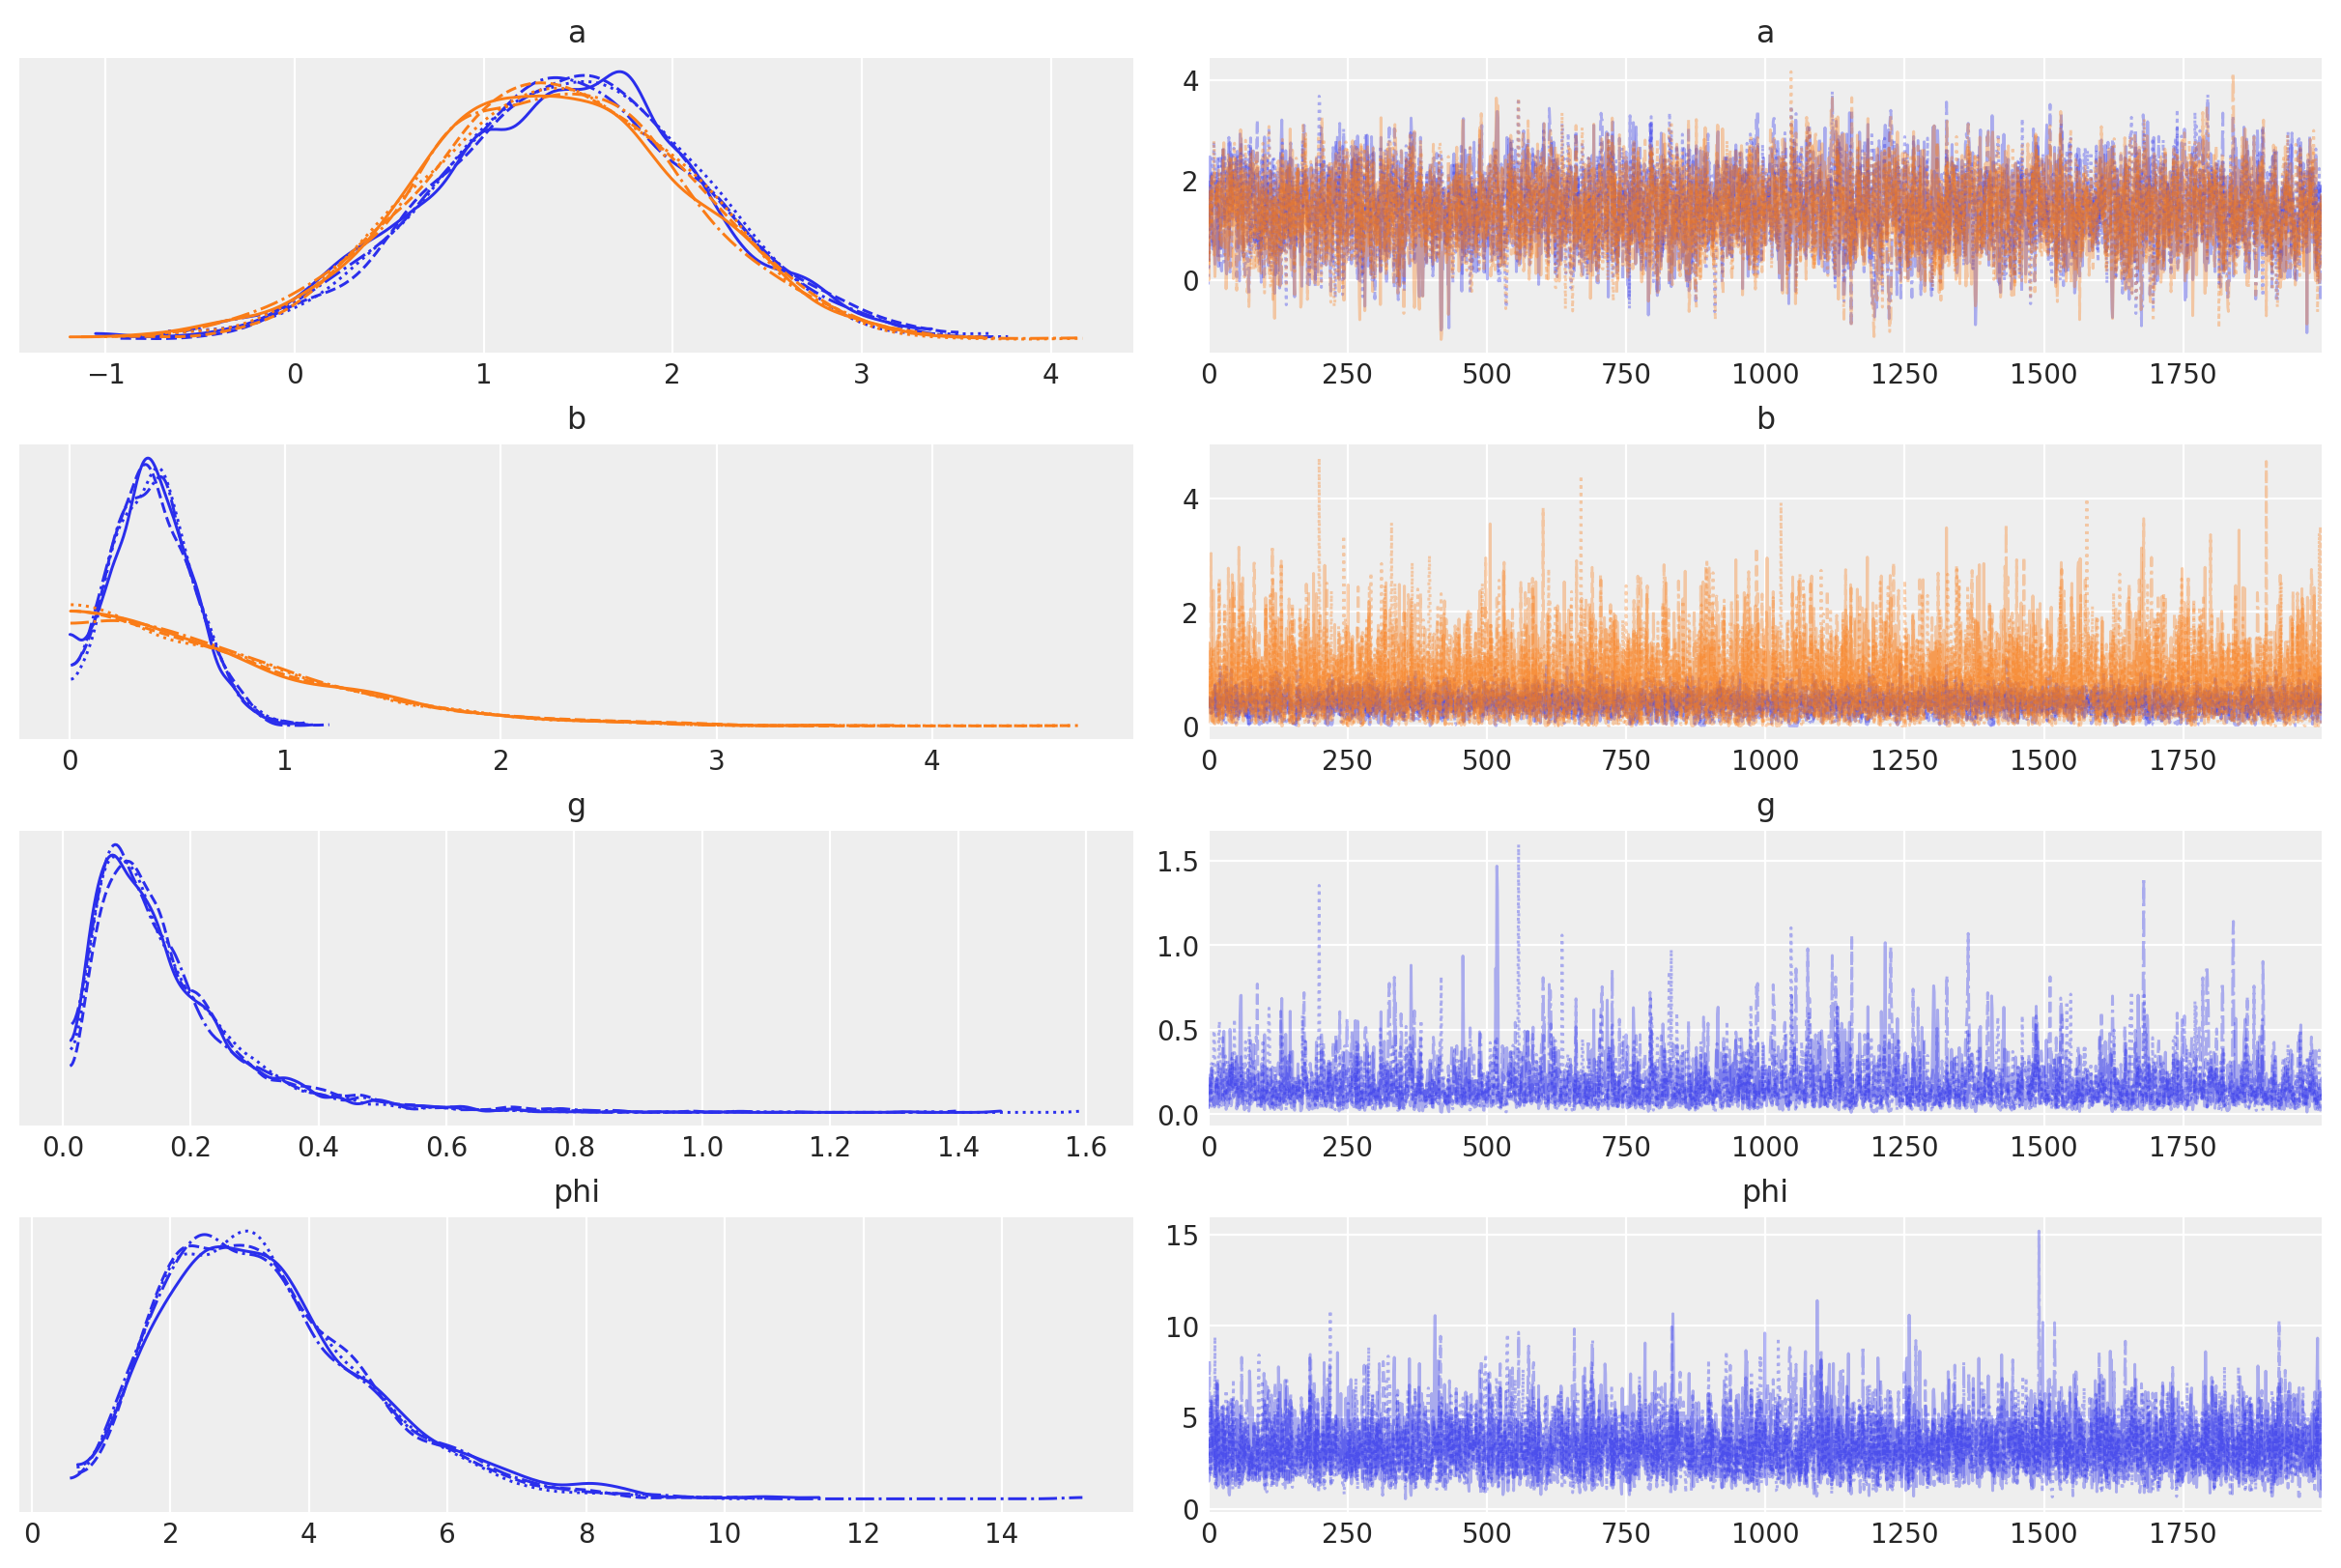

In [32]:
dk = pd.read_csv("Data/Kline", sep=";")
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0 (see chp. 11)
c_id = (dk.contact == "high").astype(int).values

with pm.Model() as m12_2:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)

    cid = pm.intX(pm.Data("cid", c_id, mutable=True))
    P_ = pm.Data("P", P, mutable=True)
    lam = (at.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.NegativeBinomial("total_tools", lam, phi, observed=dk.total_tools.values)

    trace_12_2 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_12 = az.loo(trace_12_2, pointwise=True).pareto_k.values

az.plot_trace(trace_12_2, compact=True);

#### Bonus: Figure 12.2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


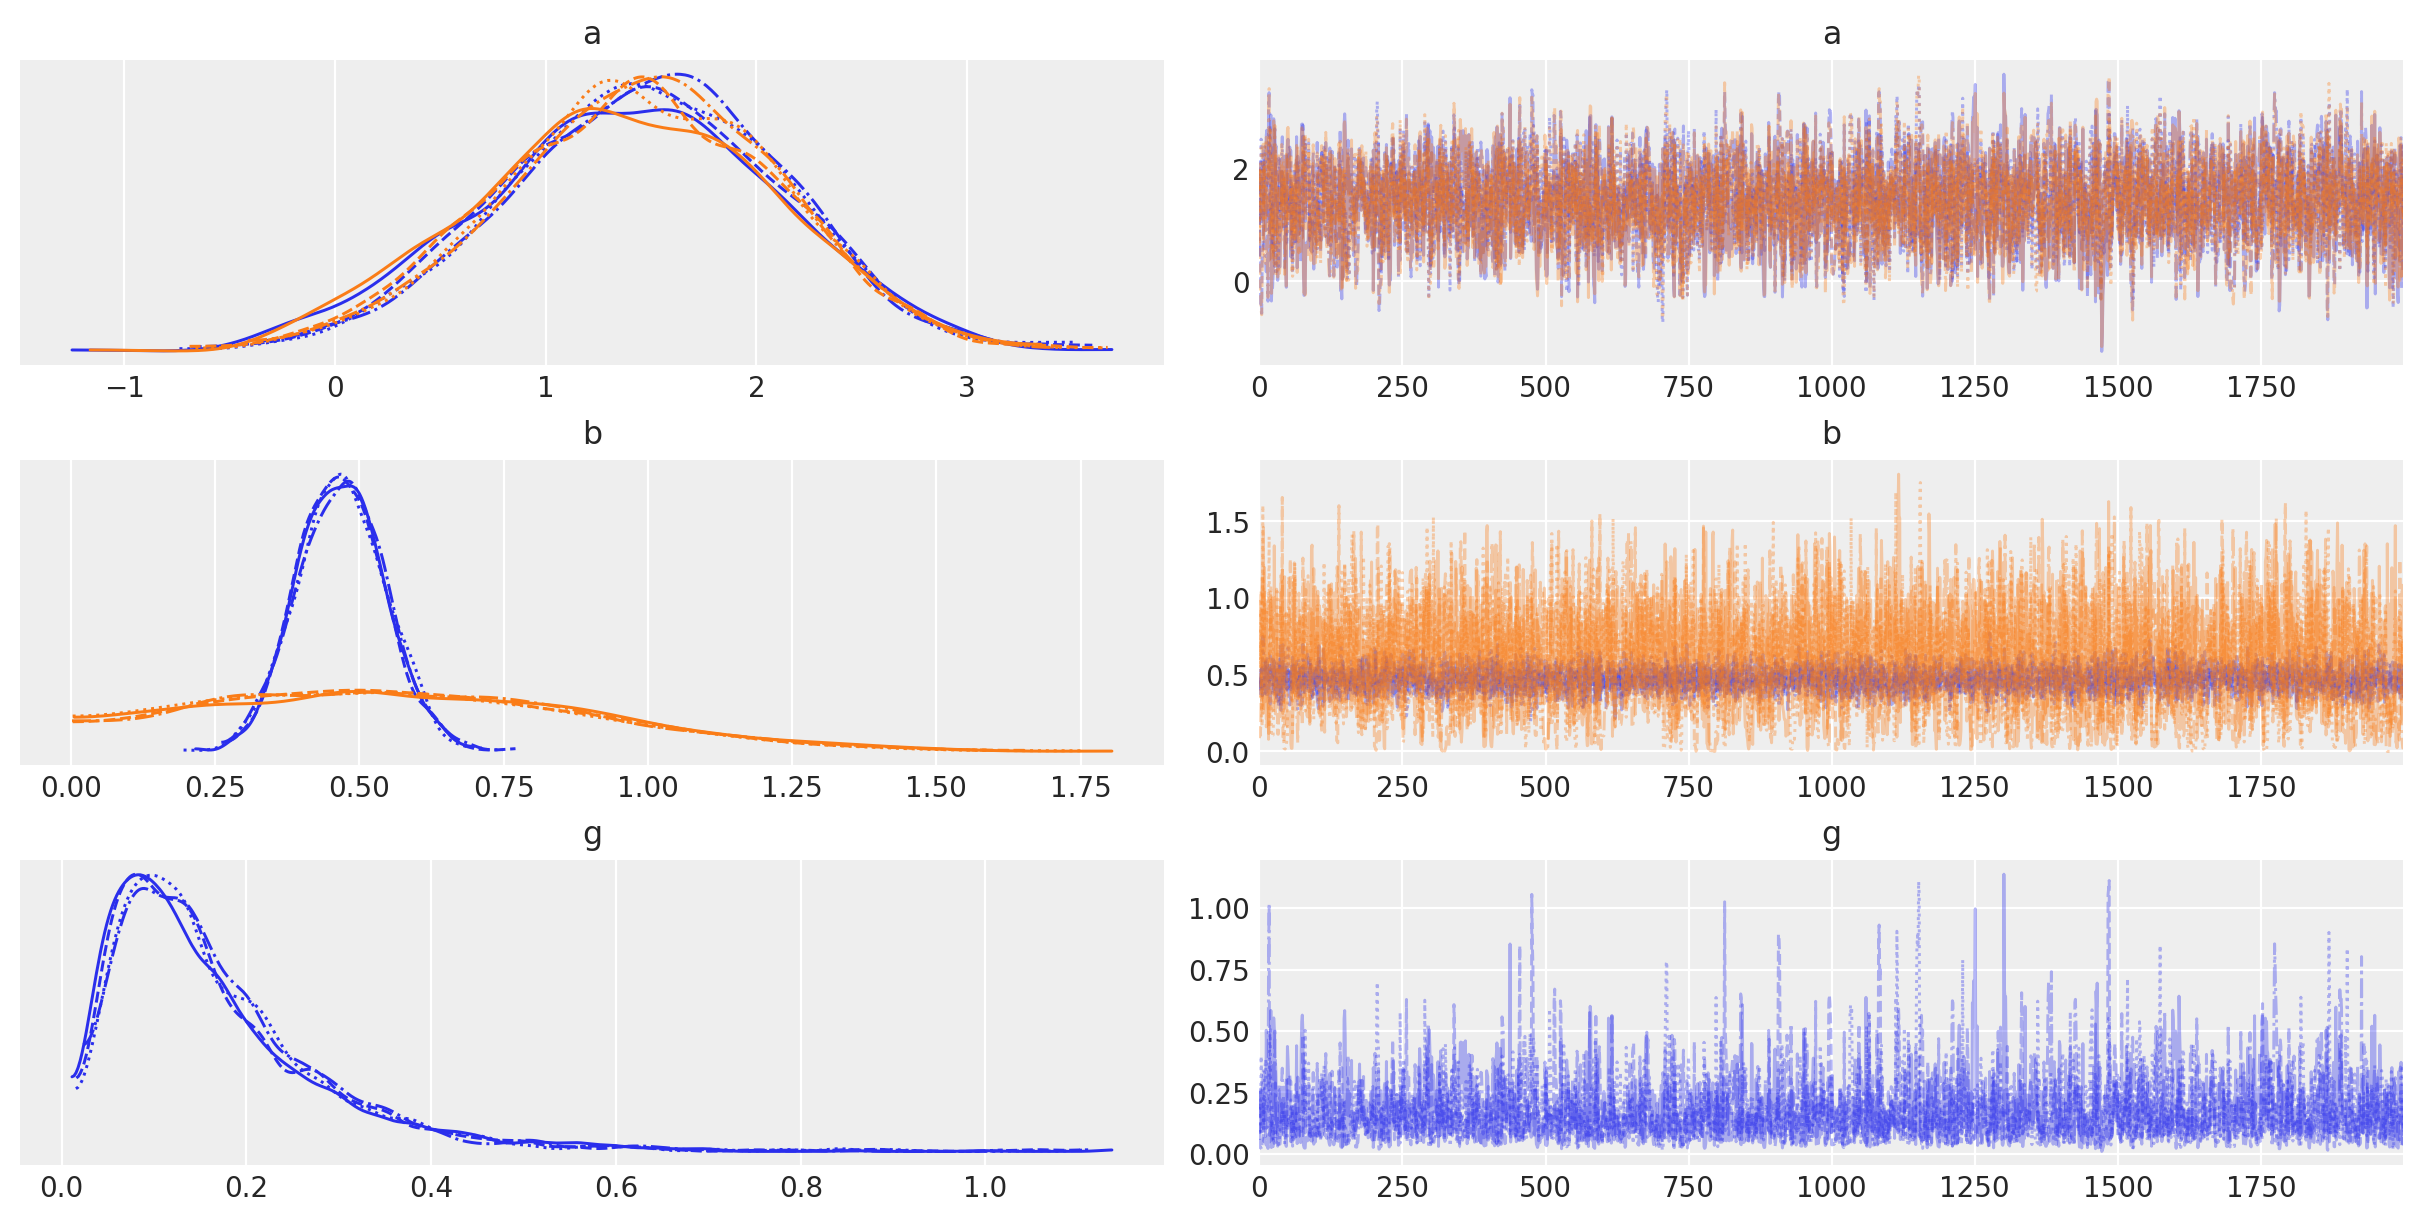

In [28]:
with pm.Model() as m11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.Data("cid", c_id, mutable=True))
    P_ = pm.Data("P", P, mutable=True)
    lam = (at.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools.values)

    trace_11_11 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

# store pareto-k values for plot:
k_11 = az.loo(trace_11_11, pointwise=True).pareto_k.values

az.plot_trace(trace_11_11, compact=True);

In [33]:
ns = 10
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_11 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1_11 = pm.sample_posterior_predictive(trace_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

with m12_2:
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_12 = pm.sample_posterior_predictive(trace_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    pm.set_data({"cid": np.array([1] * ns)})
    lam1_12 = pm.sample_posterior_predictive(trace_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

lmu0_11, lmu1_11 = lam0_11.mean(["chain", "draw"]), lam1_11.mean(["chain", "draw"])
lmu0_12, lmu1_12 = lam0_12.mean(["chain", "draw"]), lam1_12.mean(["chain", "draw"])

Sampling: [total_tools]


Sampling: [total_tools]


Sampling: [total_tools]


Sampling: [total_tools]


Text(0.5, 1.0, 'Gamma-Poisson model')

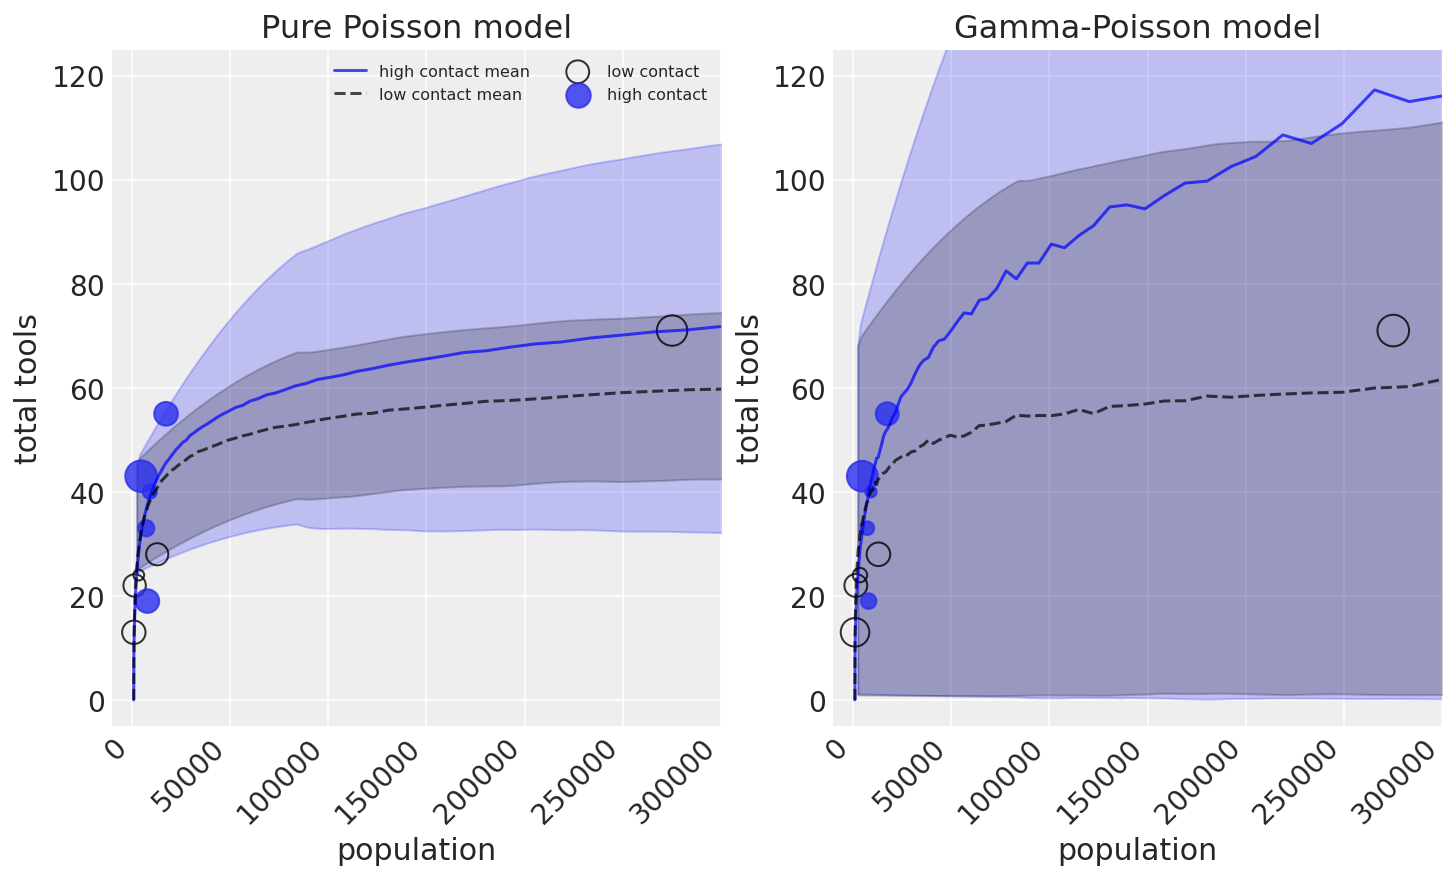

In [14]:
# scale point size to Pareto-k:
k_11 /= k_11.max()
psize_11 = 250 * k_11
k_12 /= k_12.max()
psize_12 = 250 * k_12

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

# Poisson predictions:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)
az.plot_hdi(P_seq, lam1_11, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1_11, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0_11, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0_11, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_11[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(
    dk.population[index], dk.total_tools[index], s=psize_11[index], alpha=0.8, label="high contact"
)
plt.setp(ax0.get_xticklabels(), ha="right", rotation=45)
ax0.set_xlim((-10_000, 300_000))
ax0.set_xlabel("population")
ax0.set_ylabel("total tools")
ax0.set_ylim((-5, 125))
ax0.set_title("Pure Poisson model")
ax0.legend(fontsize=8, ncol=2)

# Gamma-Poisson predictions:
az.plot_hdi(P_seq, lam1_12, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1_12, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0_12, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0_12, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_12[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize_12[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 300_000))
ax1.set_xlabel("population")
ax1.set_ylim((-5, 125))
ax1.set_ylabel("total tools")
ax1.set_title("Gamma-Poisson model")

#### Code 12.7

In [34]:
# define parameters
PROB_DRINK = 0.2  # 20% of days
RATE_WORK = 1.0  # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
drink = np.random.binomial(1, PROB_DRINK, size=N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 12.8

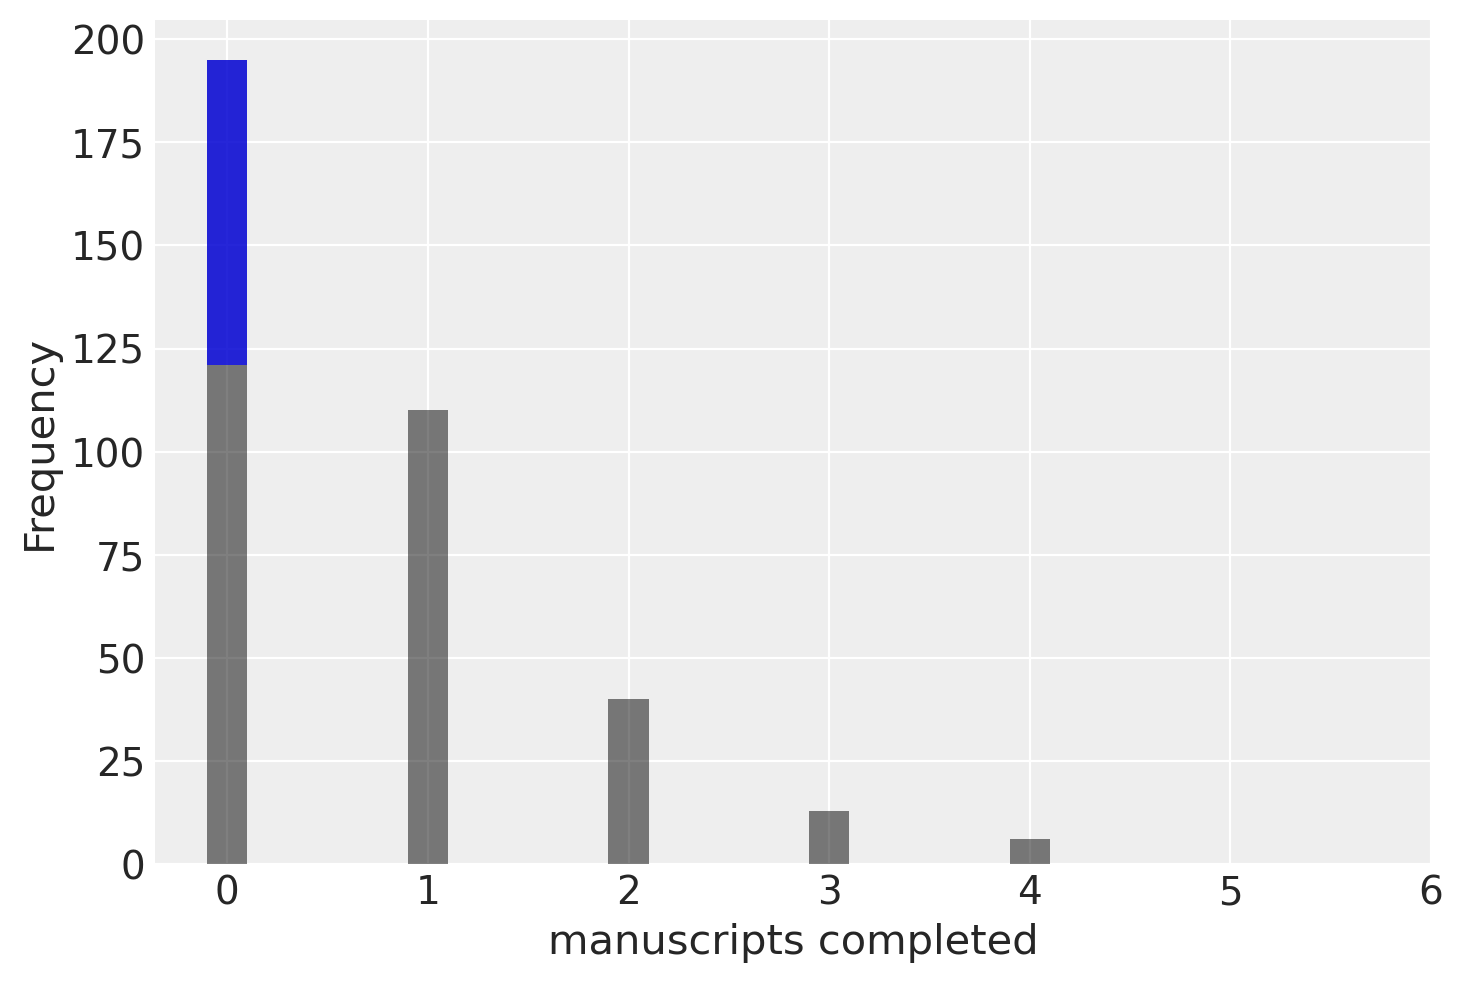

In [35]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.2, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color="b", alpha=0.7)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

#### Code 12.9

In [36]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    trace_12_3 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
az.summary(trace_12_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ap, al]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 5 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ap -1.34  0.42     -1.88      -0.65       0.01     0.01   1001.23    981.70   
al -0.08  0.10     -0.23       0.08       0.00     0.00    949.17   1020.04   

    r_hat  
ap   1.01  
al   1.00

#### Code 12.10

In [37]:
logistic(trace_12_3["posterior"]["ap"]).mean(["chain", "draw"])  # probability drink

<xarray.DataArray 'ap' ()>
array(0.2160641)

In [38]:
np.exp(trace_12_3["posterior"]["al"]).mean(
    ["chain", "draw"]
)  # rate finish manuscripts, when not drinking

<xarray.DataArray 'al' ()>
array(0.9254056)

#### Code 12.11

Stan-related

#### Code 12.12

In [40]:
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";")
trolley_df.head()

case  response  order      id  age  male            edu  action  \
0  cfaqu         4      2  96;434   14     0  Middle School       0   
1  cfbur         3     31  96;434   14     0  Middle School       0   
2  cfrub         4     16  96;434   14     0  Middle School       0   
3  cibox         3     32  96;434   14     0  Middle School       0   
4  cibur         3      4  96;434   14     0  Middle School       0   

   intention  contact story  action2  
0          0        1   aqu        1  
1          0        1   bur        1  
2          0        1   rub        1  
3          1        1   box        1  
4          1        1   bur        1

#### Code 12.13

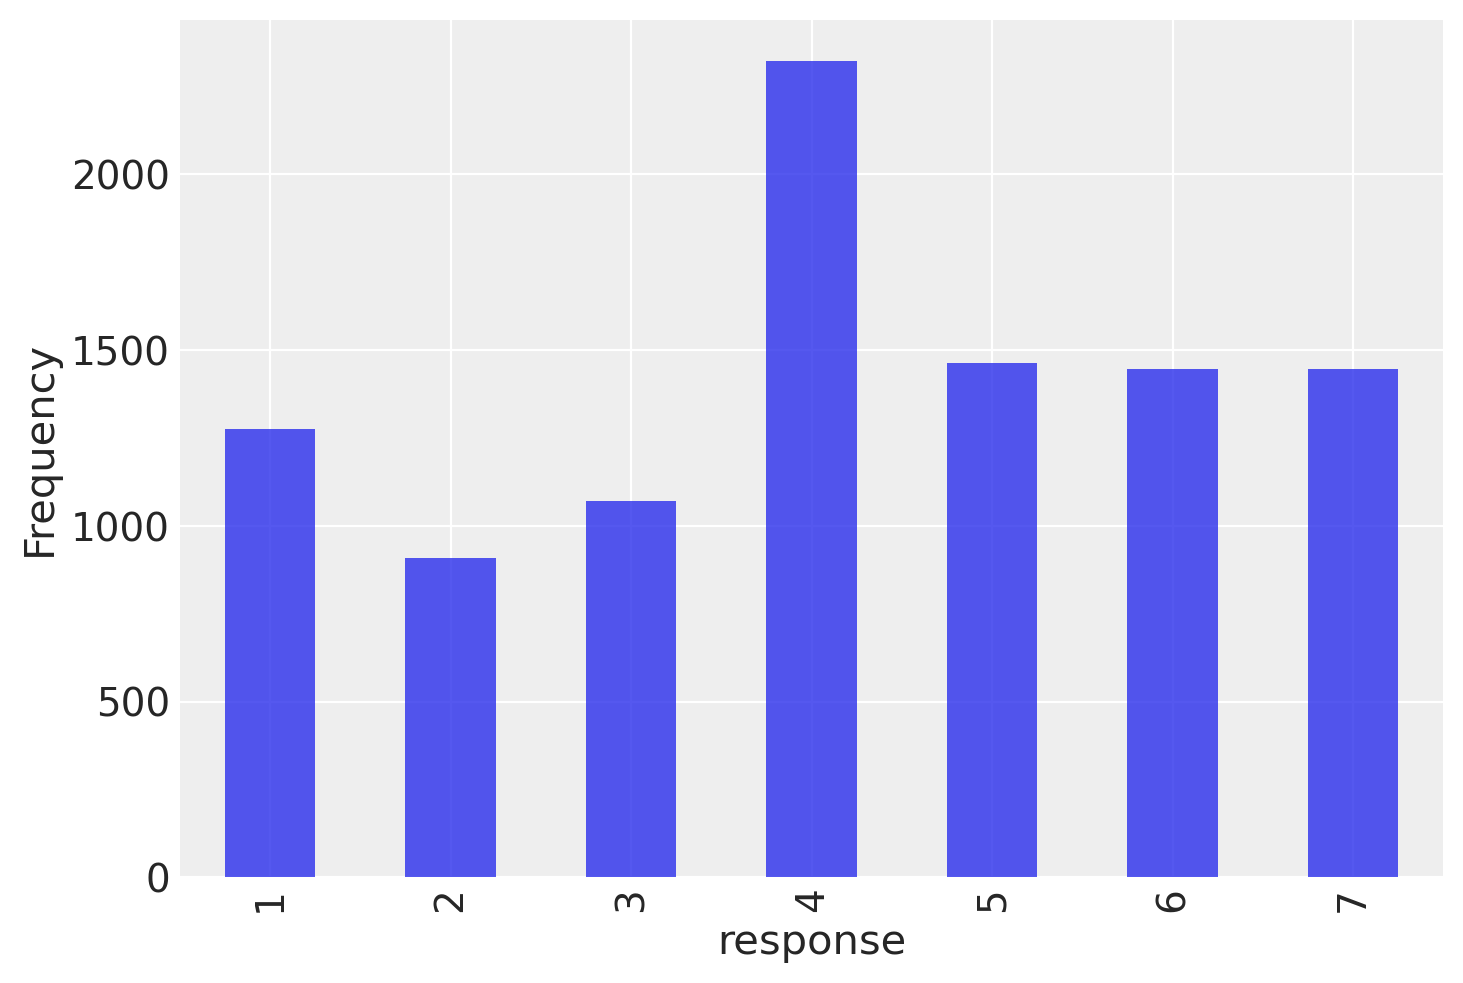

In [41]:
ax = trolley_df.response.sort_values().value_counts(sort=False).plot(kind="bar", alpha=0.8)
ax.set_xlabel("response")
ax.set_ylabel("Frequency");

#### Code 12.14

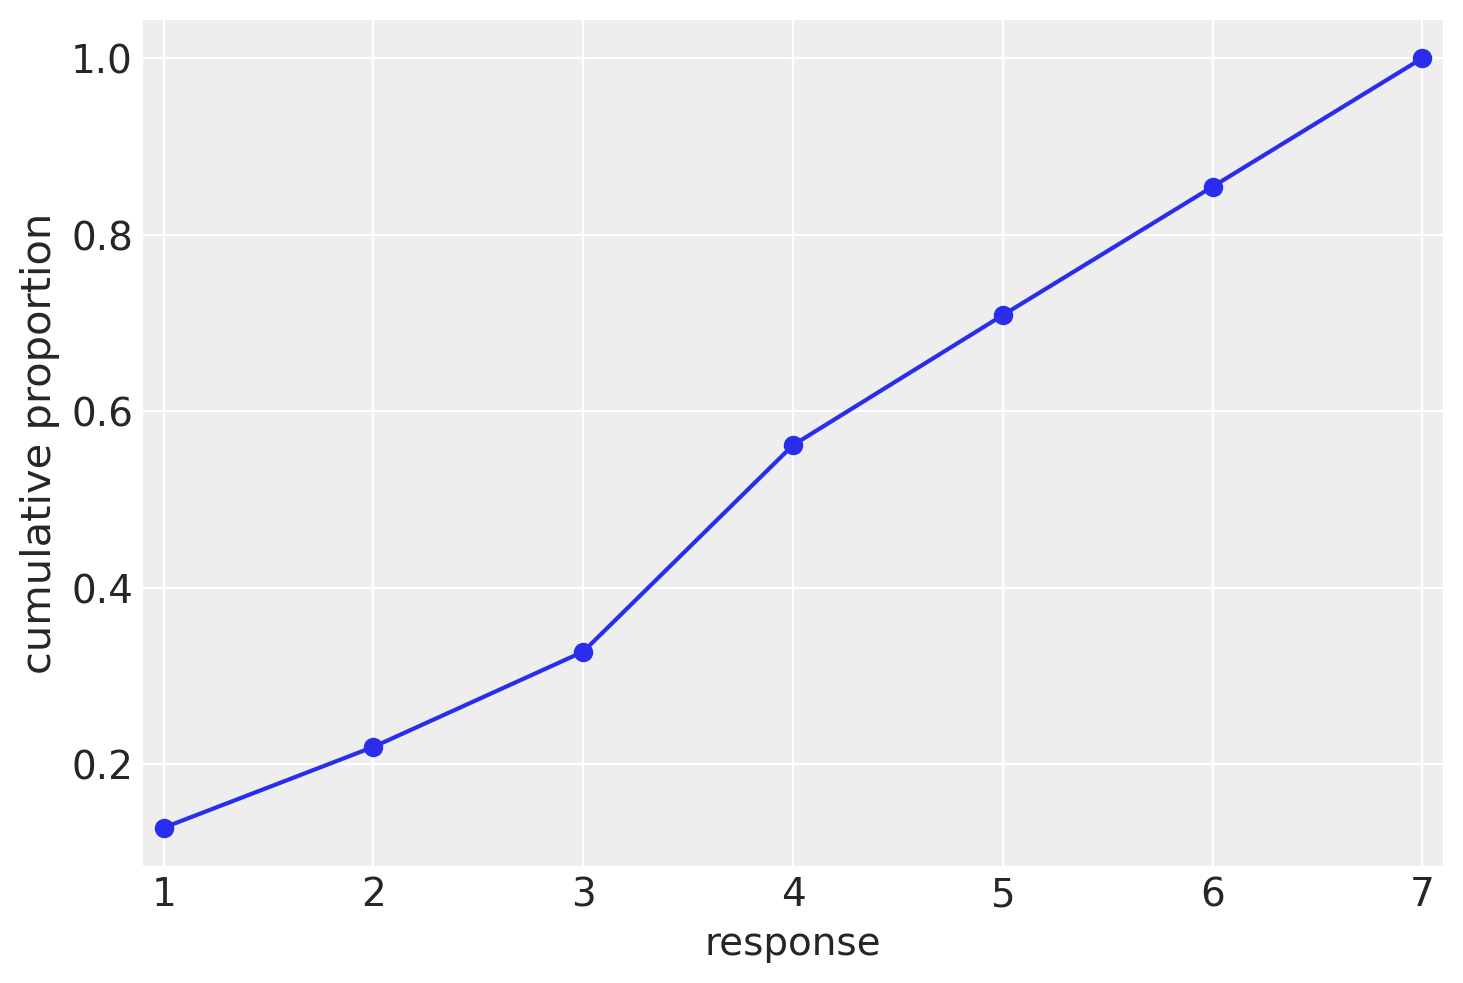

In [42]:
ax = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .plot(marker="o")
)

ax.set_xlim(0.9, 7.1)
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion");

#### Code 12.15

In [43]:
lco = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .apply(sp.special.logit)
)
lco.round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

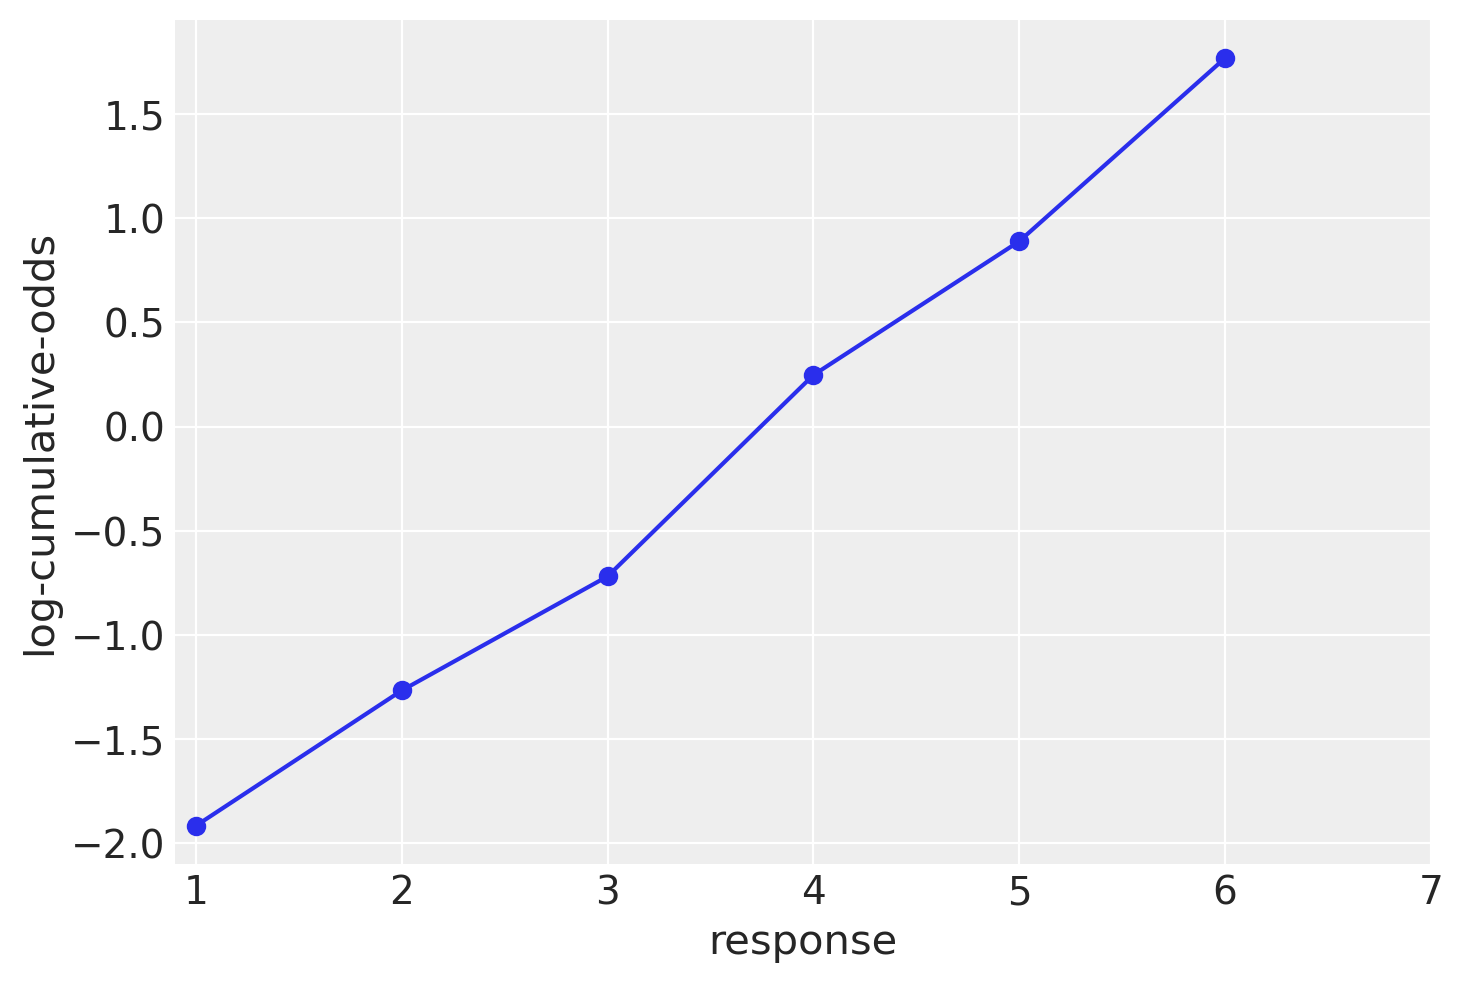

In [44]:
ax = lco.plot(marker="o")
ax.set_xlim(0.9, 7)
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative-odds");

#### Code 12.16 / 17

In [45]:
with pm.Model() as m12_4:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=trolley_df.response.values - 1)

#### Code 12.18

In [46]:
with m12_4:
    trace_12_4 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in add
  self.vm()
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in add
  self.vm()
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in add
  self.vm()
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
cutpoints[0] -1.92  0.03     -1.97      -1.88        0.0      0.0   3805.05   
cutpoints[1] -1.27  0.02     -1.31      -1.23        0.0      0.0   4912.06   
cutpoints[2] -0.72  0.02     -0.76      -0.69        0.0      0.0   4519.87   
cutpoints[3]  0.25  0.02      0.22       0.28        0.0      0.0   4426.77   
cutpoints[4]  0.89  0.02      0.85       0.93        0.0      0.0   4667.37   
cutpoints[5]  1.77  0.03      1.73       1.82        0.0      0.0   5549.65   
R_probs[0]    0.13  0.00      0.12       0.13        0.0      0.0   3805.05   
R_probs[1]    0.09  0.00      0.09       0.10        0.0      0.0   5516.75   
R_probs[2]    0.11  0.00      0.10       0.11        0.0      0.0   5316.92   
R_probs[3]    0.23  0.00      0.23       0.24        0.0      0.0   5320.47   
R_probs[4]    0.15  0.00      0.14       0.15        0.0      0.0   5682.22   
R_probs[5]    0.15  0.00      0.14       0.15        0.0      0.0   5365.93   
R_probs[6]    0.15  0.00      0.14       0.15        0.0      0.0   5549.65   

              ess_tail  r_hat  
cutpoints[0]   2912.70    1.0  
cutpoints[1]   3615.27    1.0  
cutpoints[2]   3187.12    1.0  
cutpoints[3]   3515.64    1.0  
cutpoints[4]   3165.52    1.0  
cutpoints[5]   3689.43    1.0  
R_probs[0]     2912.70    1.0  
R_probs[1]     3355.15    1.0  
R_probs[2]     3329.95    1.0  
R_probs[3]     2674.63    1.0  
R_probs[4]     2817.93    1.0  
R_probs[5]     3055.89    1.0  
R_probs[6]     3689.43    1.0

#### Code 12.19

In [47]:
logistic(trace_12_4["posterior"]["cutpoints"]).mean(["chain", "draw"]).round(3)

<xarray.DataArray 'cutpoints' (cutpoints_dim_0: 6)>
array([0.128, 0.219, 0.328, 0.562, 0.709, 0.855])
Coordinates:
  * cutpoints_dim_0  (cutpoints_dim_0) int64 0 1 2 3 4 5

#### Code 12.20

In [48]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]


pk = ordered_logistic_proba(trace_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]))
pk.round(2)

array([0.13, 0.09, 0.11, 0.23, 0.15, 0.15, 0.15])

#### Code 12.21

In [49]:
(pk * np.arange(1, 8)).sum()

4.199480186618184

#### Code 12.22

In [50]:
pk = ordered_logistic_proba(trace_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]) - 0.5)
pk.round(2)

array([0.08, 0.06, 0.08, 0.21, 0.16, 0.18, 0.22])

#### Code 12.23

In [51]:
(pk * np.arange(1, 8)).sum()

4.729224595820014

#### Code 12.24

In [53]:
R = trolley_df.response.values - 1

with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.MutableData("A", trolley_df.action.values)
    I = pm.MutableData("I", trolley_df.intention.values)
    C = pm.MutableData("C", trolley_df.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_5 = pm.sample(random_seed=RANDOM_SEED)

az.summary(trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bC, bI, bIA, bIC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 121 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bIC -1.24  0.10     -1.40      -1.09        0.0      0.0   3060.30   3128.20   
bIA -0.43  0.08     -0.57      -0.31        0.0      0.0   2725.88   2873.27   
bC  -0.34  0.07     -0.45      -0.23        0.0      0.0   3043.81   2958.13   
bI  -0.29  0.06     -0.38      -0.20        0.0      0.0   2447.74   2825.30   
bA  -0.47  0.05     -0.56      -0.38        0.0      0.0   2658.34   3066.09   

     r_hat  
bIC    1.0  
bIA    1.0  
bC     1.0  
bI     1.0  
bA     1.0

#### Code 12.25

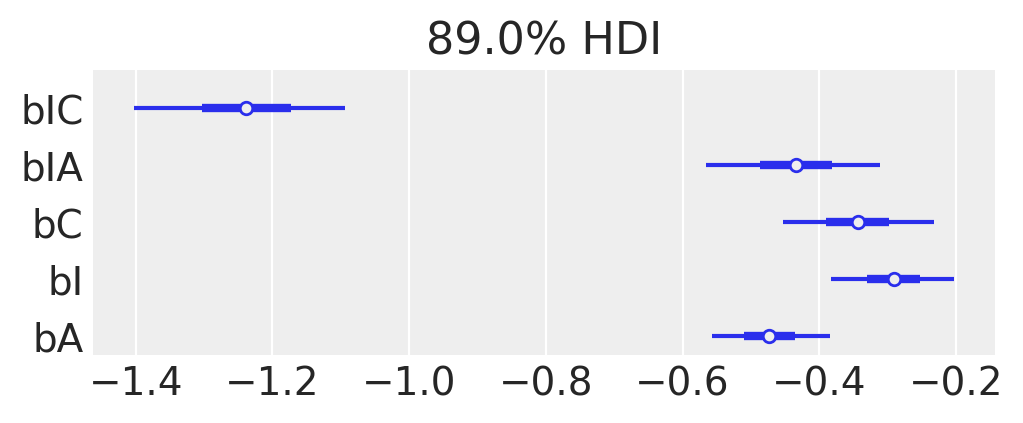

In [54]:
az.plot_forest(
    trace_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(5, 2), combined=True
);

#### Code 12.26 - 28

In [55]:
# Observed cum probs:
p_obs = (
    trolley_df.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [56]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

action  contact  intention
0       0        0          0
1       0        0          1
2       1        0          0
3       1        0          1
4       0        1          0
5       0        1          1

In [65]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(trace_12_5, var_names=["phi"], random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]

Sampling: []


In [66]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = pd.concat([cases_df, p], axis=1).set_index(["action", "contact", "intention"]).sort_index()
    p.index.name = "case"
    p.columns.name = "response"

    return p

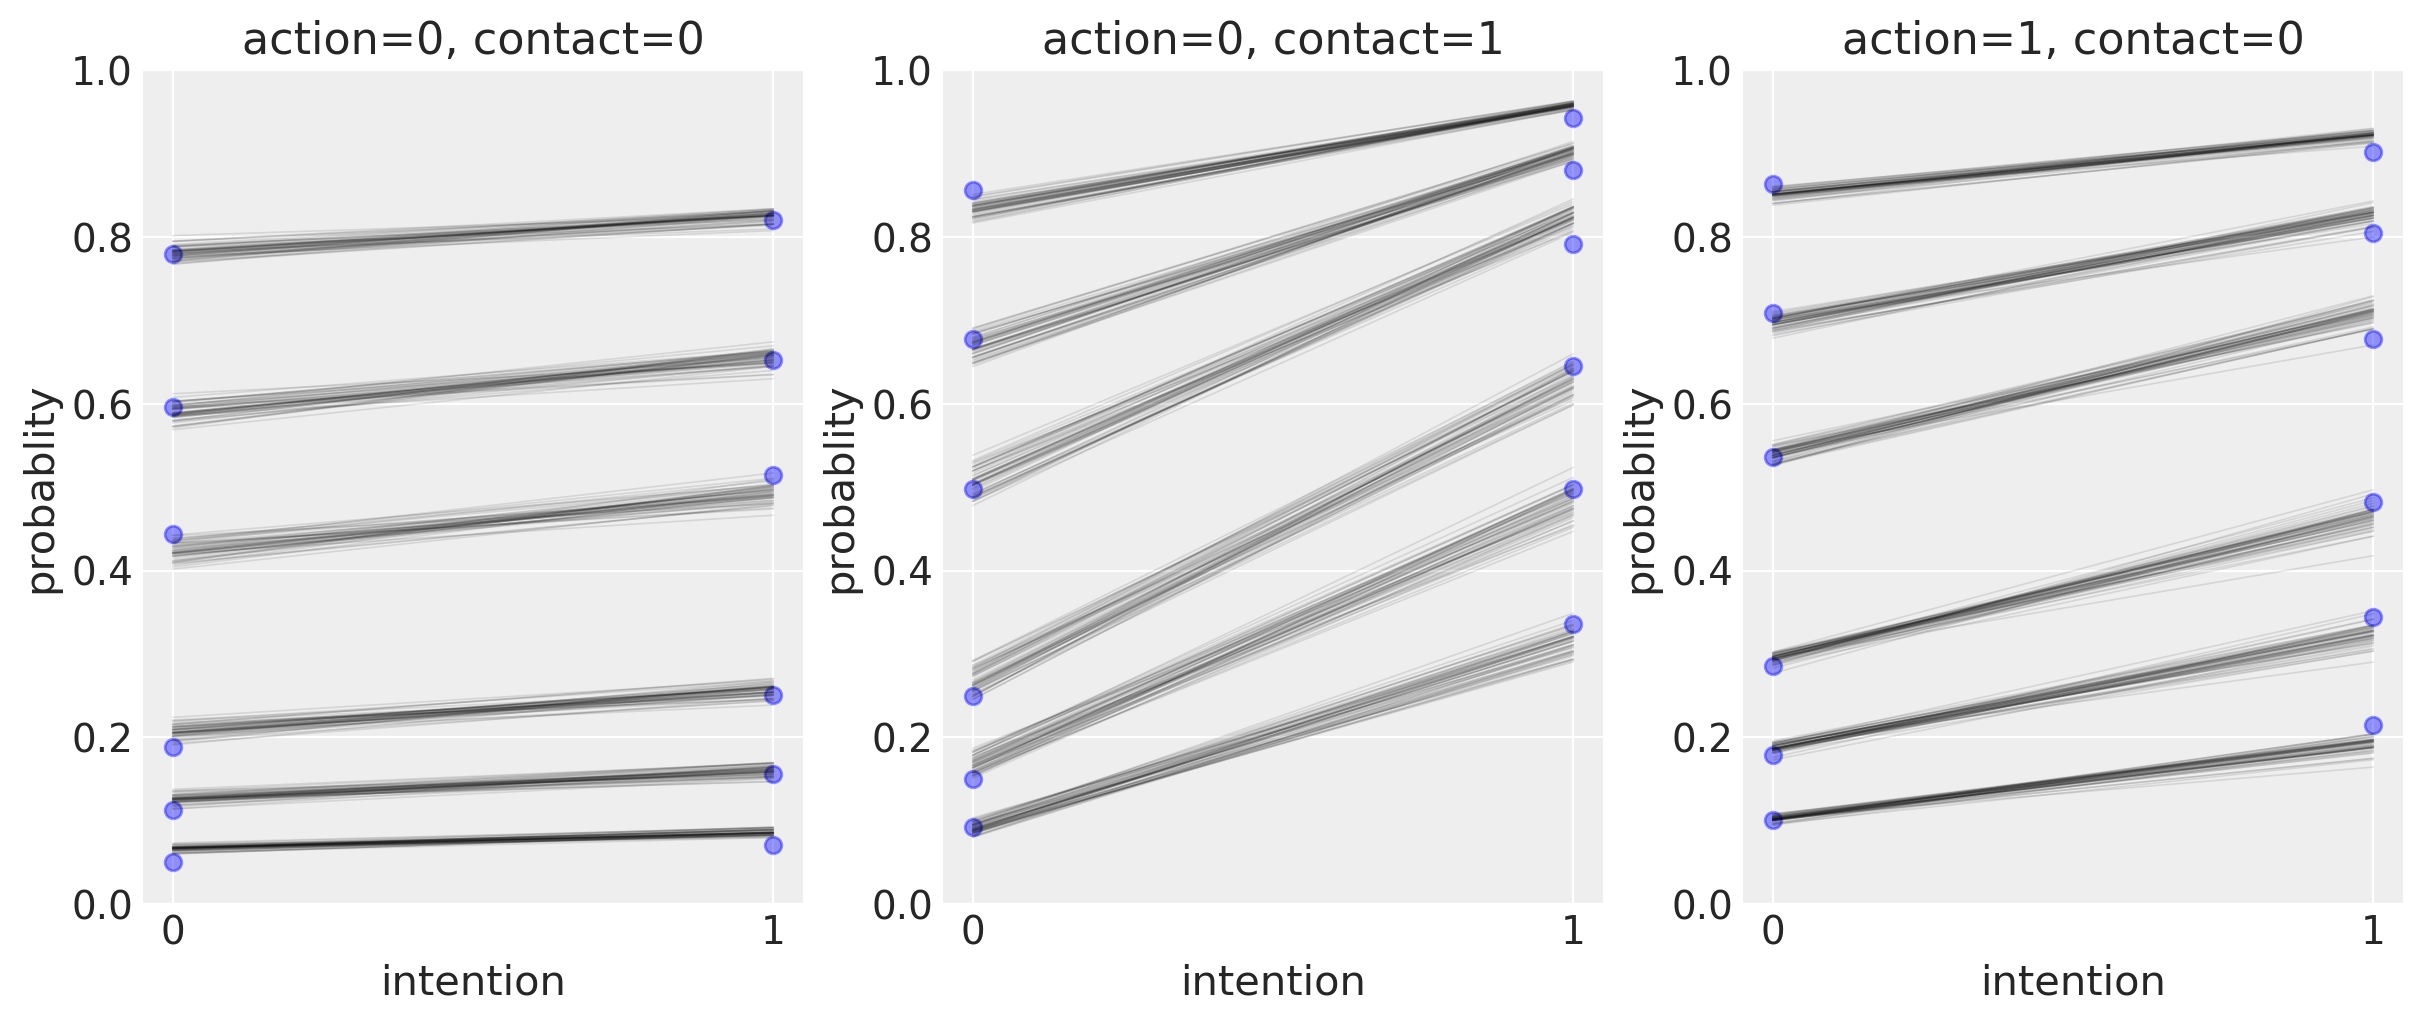

In [67]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

pp_cut_array = np.array(az.extract_dataset(trace_12_5["posterior"])["cutpoints"]).T
pp_phi_array = np.array(az.extract_dataset(pp_phi)["phi"]).T

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi_array[s], a=pp_cut_array[s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1

#### Code 12.29

In [68]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        trace_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )["posterior_predictive"]
    pp_resp_array = np.array(az.extract_dataset(pp_resp)["resp_obs"])

resp_df = pd.DataFrame(pp_resp_array)
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

Sampling: [resp_obs]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (9930,).
Apply node that caused the error: categorical_rv{0, (1,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F74C2855A80>), TensorConstant{(1,) of 9930}, TensorConstant{4}, Elemwise{sub,no_inplace}.0)
Toposort index: 63
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, (None, None))]
Inputs shapes: ['No shapes', (1,), (), (6, 7)]
Inputs strides: ['No strides', (8,), (), (56, 8)]
Inputs values: [Generator(PCG64) at 0x7F74C2855A80, array([9930]), array(4), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

/tmp/ipykernel_589/2647063190.py:10: PerformanceWarning: indexing past lexsort depth may impact performance.
  [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],


ValueError: x must have 2 or fewer dimensions

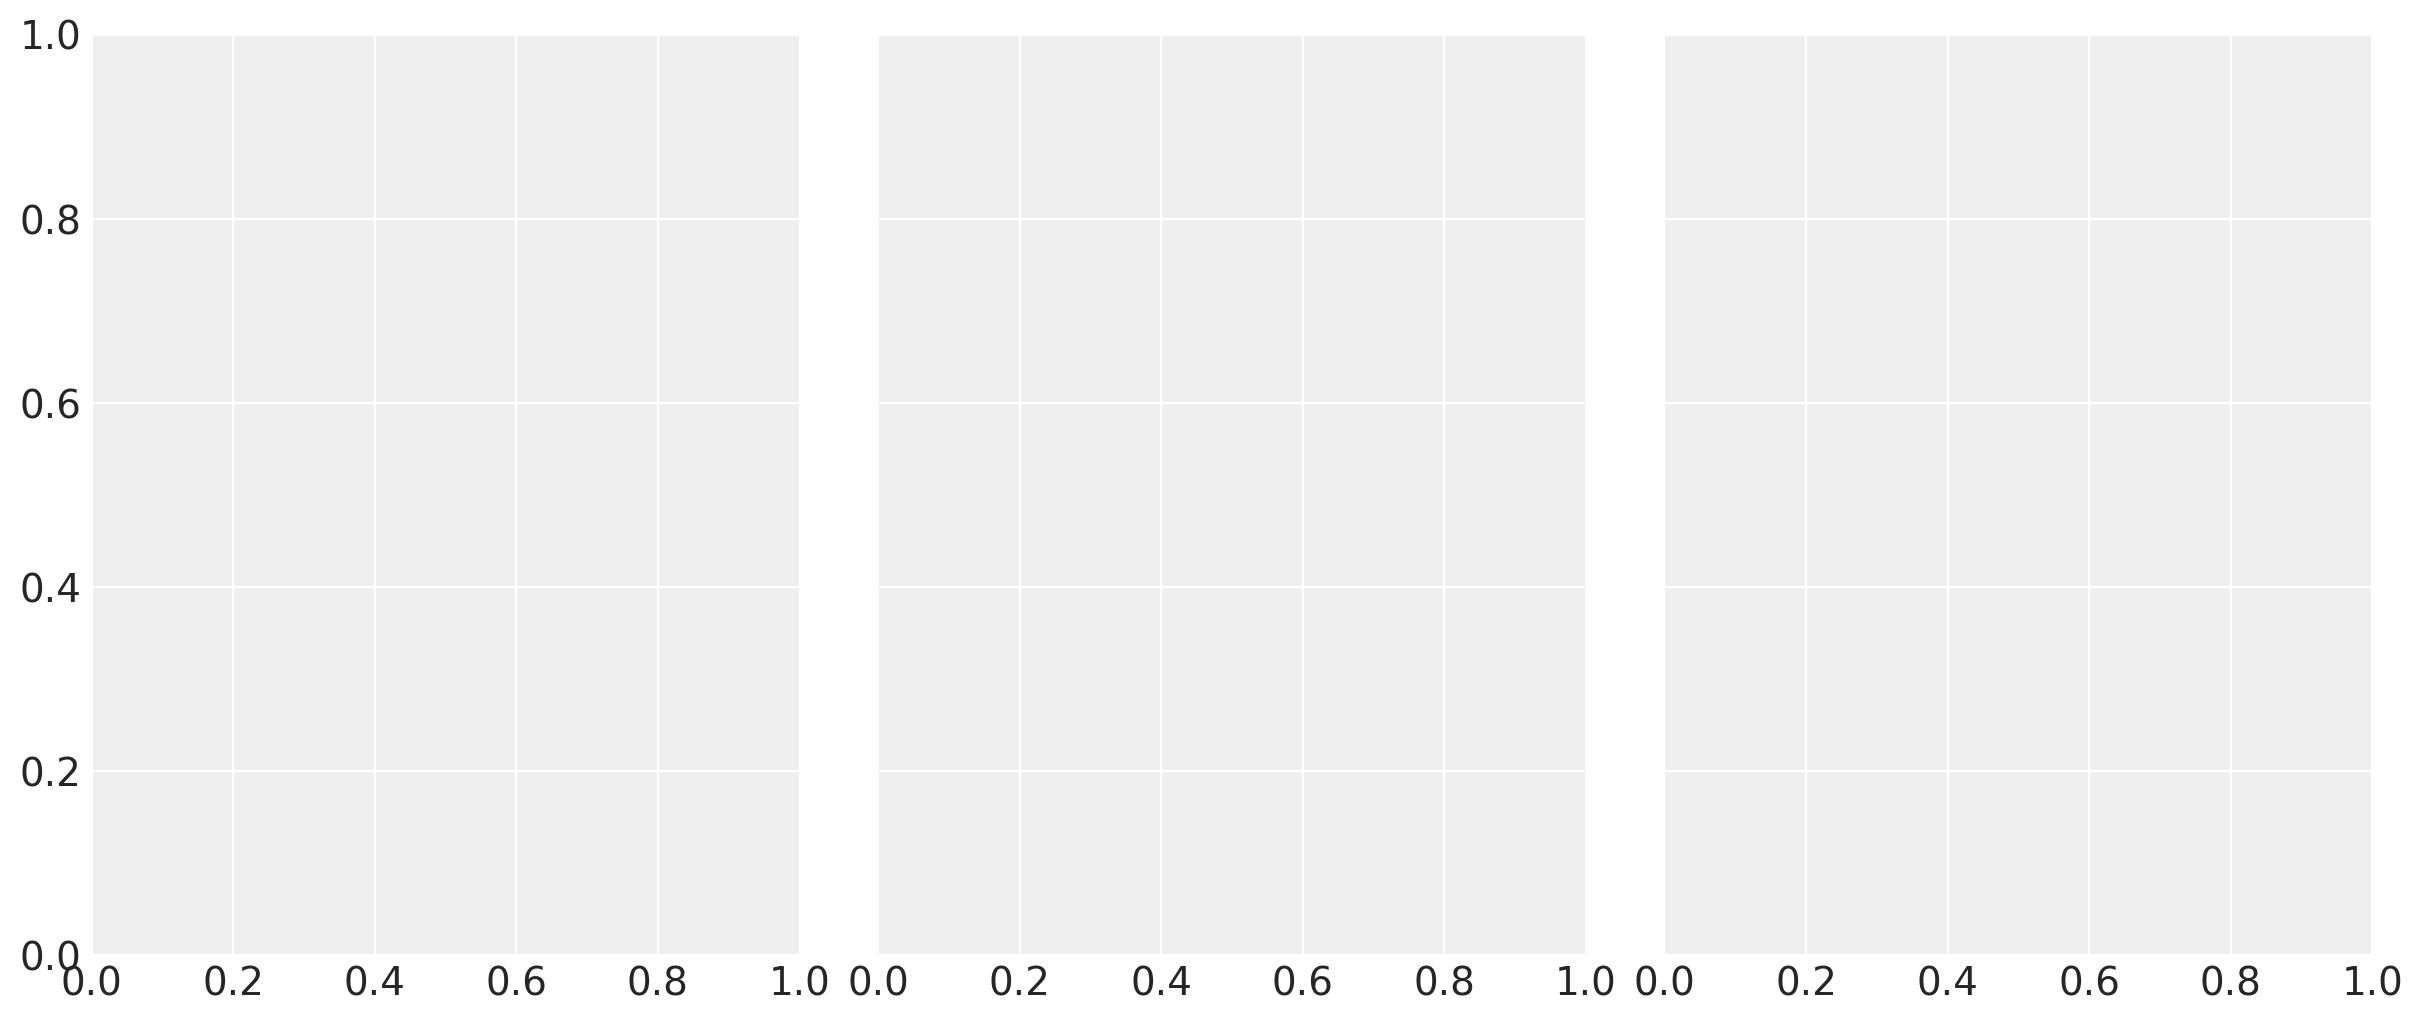

In [64]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")

#### Code 12.30

In [41]:
pd.Categorical(trolley_df.edu)

['Middle School', 'Middle School', 'Middle School', 'Middle School', 'Middle School', ..., 'Graduate Degree', 'Graduate Degree', 'Graduate Degree', 'Graduate Degree', 'Graduate Degree']
Length: 9930
Categories (8, object): ['Bachelor's Degree', 'Elementary School', 'Graduate Degree', 'High School Graduate', 'Master's Degree', 'Middle School', 'Some College', 'Some High School']

#### Code 12.31

In [70]:
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes

#### Code 12.32

In [71]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

#### Code 12.33

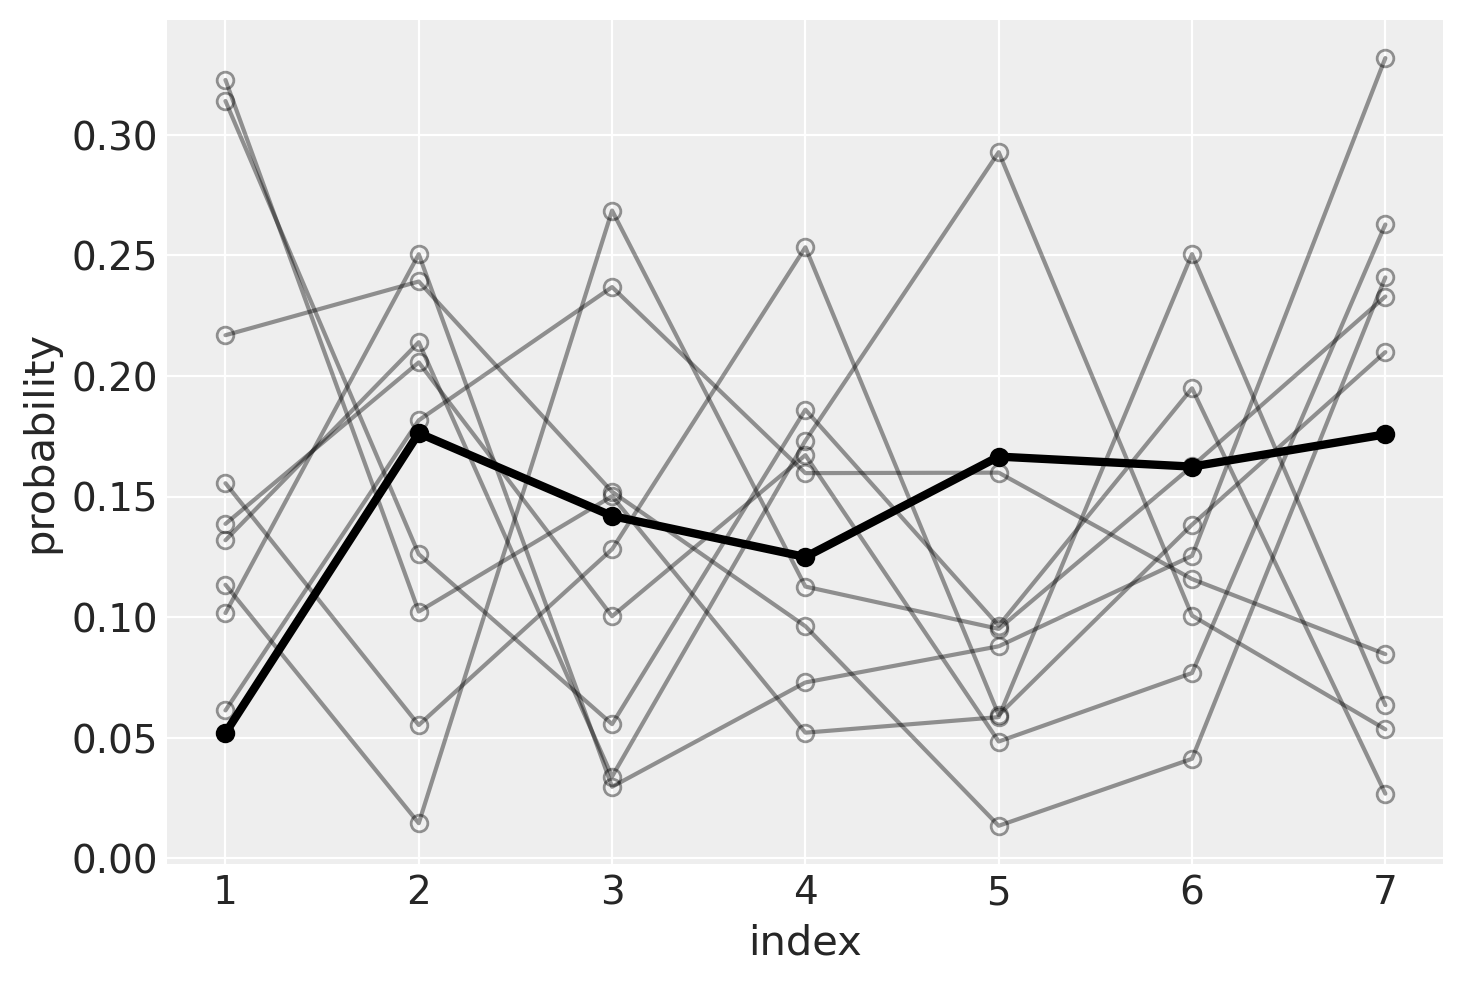

In [72]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

#### Code 12.34

In [73]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values

with pm.Model() as m12_6:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = at.concatenate([at.zeros(1), delta])
    delta_j_cumulative = at.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    trace_12_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa, bA, bC, bI, bE, delta]


/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 759 seconds.


#### Code 12.35

In [74]:
az.summary(trace_12_6, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
bA       -0.70  0.04     -0.76      -0.63        0.0      0.0   5650.85   
bC       -0.95  0.05     -1.03      -0.87        0.0      0.0   5882.18   
bI       -0.72  0.04     -0.77      -0.66        0.0      0.0   7635.74   
bE       -0.29  0.16     -0.55      -0.05        0.0      0.0   3102.60   
delta[0]  0.22  0.13      0.02       0.40        0.0      0.0   4891.07   
delta[1]  0.14  0.09      0.01       0.27        0.0      0.0   7472.74   
delta[2]  0.19  0.11      0.02       0.35        0.0      0.0   7782.13   
delta[3]  0.17  0.10      0.02       0.32        0.0      0.0   5548.74   
delta[4]  0.05  0.06      0.00       0.09        0.0      0.0   3607.78   
delta[5]  0.10  0.07      0.01       0.19        0.0      0.0   5997.53   
delta[6]  0.13  0.08      0.01       0.23        0.0      0.0   7023.30   

          ess_tail  r_hat  
bA         5237.63    1.0  
bC         6001.14    1.0  
bI         6069.47    1.0  
bE         3197.87    1.0  
delta[0]   4198.59    1.0  
delta[1]   4111.31    1.0  
delta[2]   4786.52    1.0  
delta[3]   3990.11    1.0  
delta[4]   3249.26    1.0  
delta[5]   5124.65    1.0  
delta[6]   5095.50    1.0

#### Code 12.36

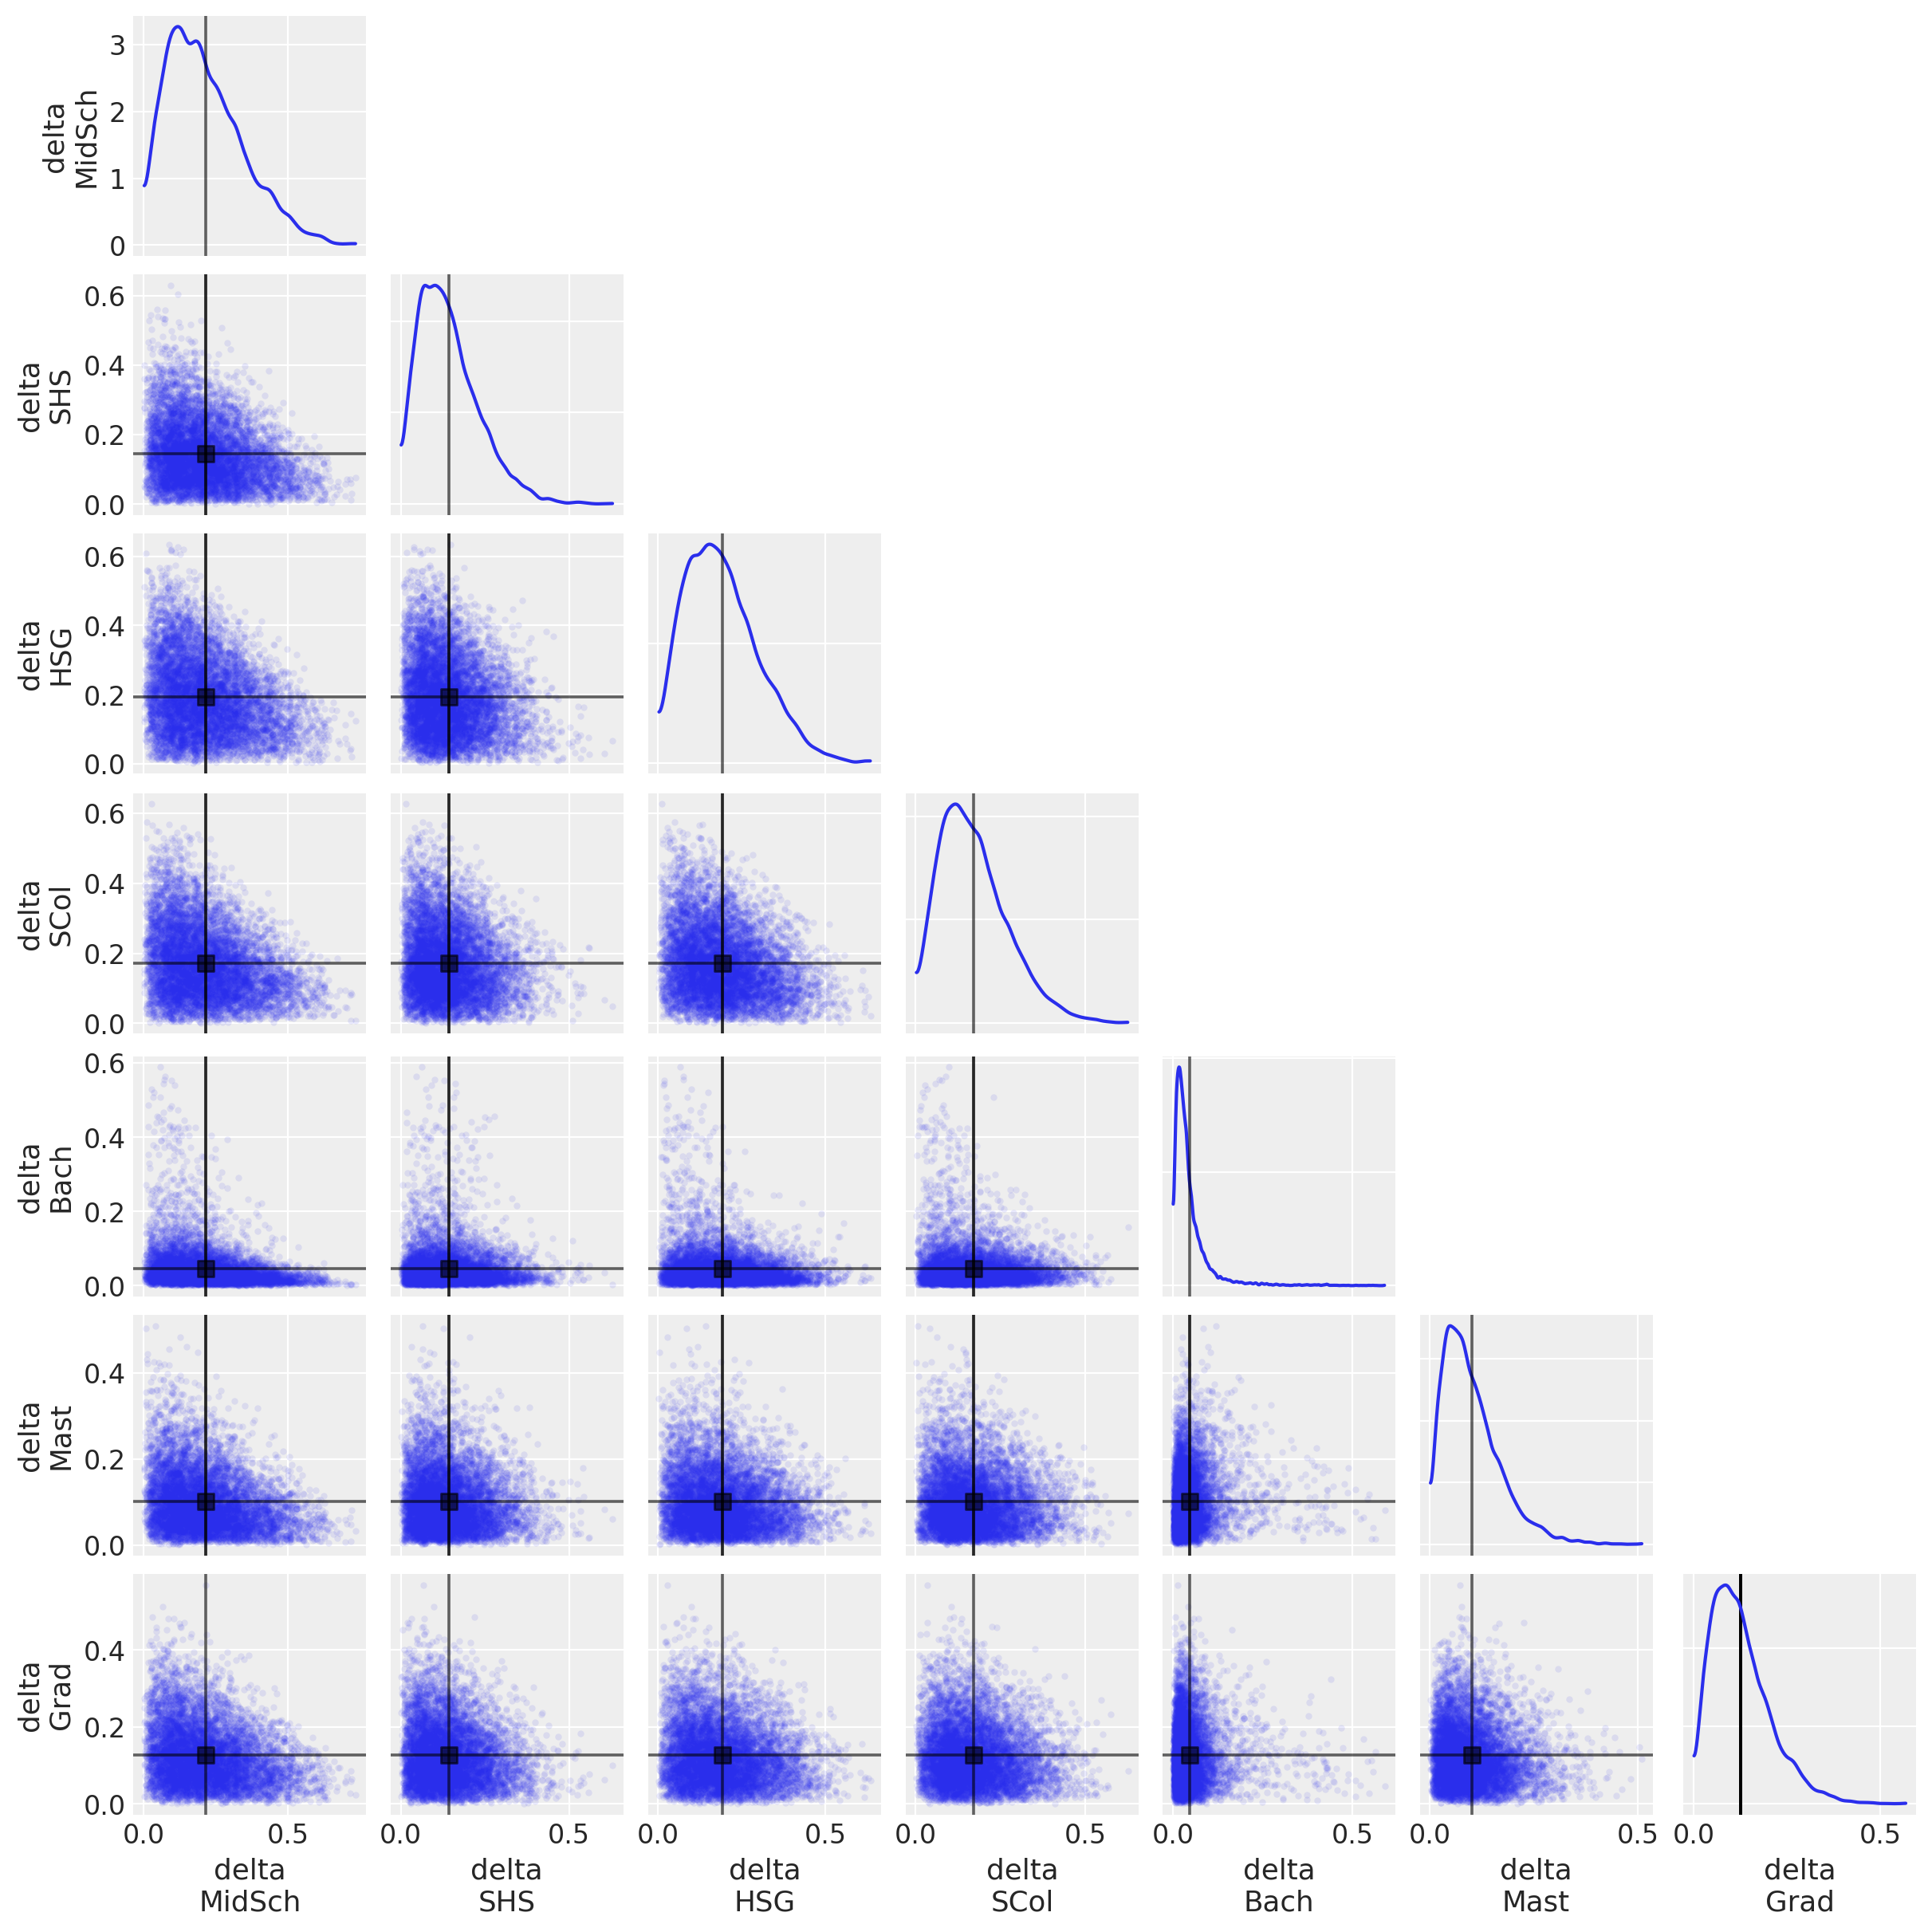

In [75]:
trace_12_6.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

az.plot_pair(
    trace_12_6,
    var_names=["delta"],
    marginals=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);

#### Code 12.37

In [76]:
edu_norm = (
    (trolley_df.edu_new - trolley_df.edu_new.min())
    / (trolley_df.edu_new.max() - trolley_df.edu_new.min())
).values

with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    trace_12_7 = pm.sample(random_seed=RANDOM_SEED)
az.summary(trace_12_7, var_names=["bA", "bC", "bI", "bE"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bC, bI, bE]


/work/SamueleSoraggi#7953/Repositories/bayesian_statistics/statistical_rethinking_2/pymc4/pymc4_env/lib/python3.10/site-packages/aesara/compile/function/types.py:971: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
bA -0.70  0.04     -0.76      -0.63        0.0      0.0   3496.88   3004.21   
bC -0.95  0.05     -1.04      -0.87        0.0      0.0   3388.29   2836.35   
bI -0.71  0.04     -0.78      -0.66        0.0      0.0   4868.82   3060.60   
bE -0.09  0.09     -0.24       0.04        0.0      0.0   3809.07   3274.15   

    r_hat  
bA    1.0  
bC    1.0  
bI    1.0  
bE    1.0

In [77]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 19 2023

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

aesara    : 2.8.7
pandas    : 1.5.3
scipy     : 1.10.1
matplotlib: 3.7.1
arviz     : 0.13.0
numpy     : 1.24.2
pymc      : 4.3.0

Watermark: 2.3.1

